In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import random
import time

import matplotlib.pyplot as plt

import numpy as np

In [0]:

import os
import sys

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:

data_dir = '/content/drive/My Drive/raw_data/meme_breeds'

transformations = transforms.Compose([
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [0]:
data = datasets.ImageFolder(data_dir, transform = transformations)

In [0]:
n_train_and_valid_examples = int(len(data)*0.85)
n_test_examples = len(data) - n_train_and_valid_examples

train_and_valid_data, test_data = torch.utils.data.random_split(data, 
                                                       [n_train_and_valid_examples, n_test_examples])

n_train_examples = int(len(train_and_valid_data)*0.70)
n_valid_examples = len(train_and_valid_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, 
                                                       [n_train_examples, n_valid_examples])

In [26]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4009
Number of validation examples: 1719
Number of testing examples: 1011


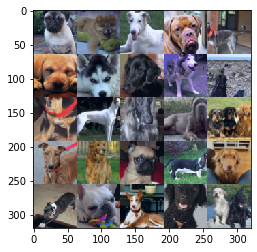

In [27]:
n_imgs = 25

batch = torch.zeros(n_imgs, 3, 64, 64)

for i in range(n_imgs):
    img, _ = train_data[i]
    batch[i] = img
        
grid_img = torchvision.utils.make_grid(batch, 
                                       nrow = 5,
                                       padding = 0,
                                       normalize = True)

plt.imshow(grid_img.permute(1, 2, 0))

In [0]:
BATCH_SIZE = 16

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size = BATCH_SIZE)

In [0]:

class MLP(nn.Module):
    def __init__(self, input_dim, hid_dims, output_dim):
        super().__init__()
        
        assert len(hid_dims) > 0
        
        self.input_fc = nn.Linear(input_dim, hid_dims[0])
        
        self.fcs = nn.ModuleList([nn.Linear(hid_dims[i], hid_dims[i+1]) 
                                  for i in range(len(hid_dims)-1)])
        
        self.output_fc = nn.Linear(hid_dims[-1], output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]

        x = x.view(x.shape[0], -1)
        
        #x = [batch size, height * width]
        
        x = F.relu(self.input_fc(x))
        
        #x = [batch size, hid dims[0]]
        
        for fc in self.fcs:
            x = F.relu(fc(x))
        
        #x = [batch size, hid dims[-1]]
        
        x = self.output_fc(x)
        
        #x = [batch size, output dim]
        
        return x

In [0]:
INPUT_DIM = 64 * 64 * 3
HID_DIMS = [1000, 500, 250]
OUTPUT_DIM = 7

model = MLP(INPUT_DIM, HID_DIMS, OUTPUT_DIM)

In [31]:
model


MLP(
  (input_fc): Linear(in_features=12288, out_features=1000, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=1000, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=250, bias=True)
  )
  (output_fc): Linear(in_features=250, out_features=7, bias=True)
)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,916,507 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())


In [0]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
def calculate_accuracy(fx, y):
    preds = fx.argmax(1, keepdim=True)
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [0]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

EPOCHS = 20
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    train_loss_list += [train_loss]
    train_acc_list += [train_acc]
    valid_loss_list += [valid_loss]
    valid_acc_list += [valid_acc]
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 42s
	Train Loss: 1.872 | Train Acc: 27.82%
	 Val. Loss: 1.788 |  Val. Acc: 29.70%
Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 1.753 | Train Acc: 32.36%
	 Val. Loss: 1.755 |  Val. Acc: 31.71%
Epoch: 03 | Epoch Time: 0m 42s
	Train Loss: 1.679 | Train Acc: 36.08%
	 Val. Loss: 1.733 |  Val. Acc: 33.15%
Epoch: 04 | Epoch Time: 0m 43s
	Train Loss: 1.604 | Train Acc: 39.64%
	 Val. Loss: 1.733 |  Val. Acc: 34.12%
Epoch: 05 | Epoch Time: 0m 42s
	Train Loss: 1.513 | Train Acc: 42.45%
	 Val. Loss: 1.745 |  Val. Acc: 35.80%
Epoch: 06 | Epoch Time: 0m 42s
	Train Loss: 1.433 | Train Acc: 46.70%
	 Val. Loss: 1.756 |  Val. Acc: 36.84%
Epoch: 07 | Epoch Time: 0m 42s
	Train Loss: 1.326 | Train Acc: 50.59%
	 Val. Loss: 1.809 |  Val. Acc: 36.82%
Epoch: 08 | Epoch Time: 0m 42s
	Train Loss: 1.266 | Train Acc: 52.76%
	 Val. Loss: 1.899 |  Val. Acc: 34.87%
Epoch: 09 | Epoch Time: 0m 42s
	Train Loss: 1.141 | Train Acc: 57.52%
	 Val. Loss: 1.986 |  Val. Acc: 38.17%
Epoch: 10 | Epoch T

In [41]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.761 | Test Acc: 32.49%


In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/raw_data/meme_breeds/mlp-model.pt')

In [0]:
model.load_state_dict(torch.load('/content/drive/My Drive/raw_data/meme_breeds/mlp-model.pt',map_location={'cuda:0': 'cpu'}))

<All keys matched successfully>

In [0]:
tensor(1, device='cuda:0').numpy()

NameError: ignored

[tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1)

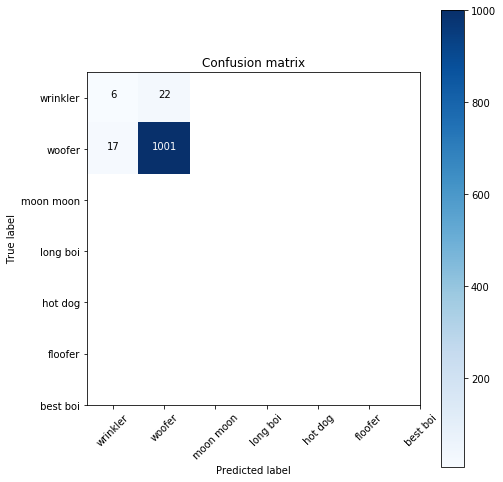

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def evaluate_pred(model, iterator, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    fx = []
    y_l = []
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)
            y_l += list(y.cpu())

            fx += list(model(x).argmax(dim=1).cpu())
    return y_l,fx
import itertools
x,y = evaluate_pred(model, test_iterator, device)
print(x,y)
cm = confusion_matrix(x, y)
names = ('wrinkler','woofer','moon moon','long boi',' hot dog', 'floofer',' best boi')
plt.figure(figsize=(7,7))
plot_confusion_matrix(cm, names)

**2 - LeNet-5 MNIST.ipynb**

In [0]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size = BATCH_SIZE)

In [0]:
class LeNet(nn.Module):    
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, 
                               out_channels = 6, 
                               kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 16, 
                               kernel_size = 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

In [0]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

In [0]:
model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
criterion = nn.CrossEntropyLoss()


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [0]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

KeyboardInterrupt: ignored